In [54]:
import tensorflow as tf
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import datetime as dt

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

## 데이터 로드

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values( ['Time'], inplace=True)  # data를 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
1000138,6040,858,4,956703932
1000153,6040,2384,4,956703954
999873,6040,593,5,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977
...,...,...,...,...
825793,4958,2399,1,1046454338
825438,4958,1407,5,1046454443
825724,4958,3264,4,1046454548
825731,4958,2634,3,1046454548


In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [5]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [7]:
user_length.quantile(0.999)

1343.181000000005

In [8]:
user_length.min(), user_length.max()

(20, 2314)

In [10]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time,UTC
697219,4169,2653,4,965333392,2000-08-03 20:09:52
696969,4169,1268,5,965333392,2000-08-03 20:09:52
697275,4169,423,3,965333392,2000-08-03 20:09:52
697185,4169,2628,4,965333392,2000-08-03 20:09:52
697168,4169,2617,4,965333392,2000-08-03 20:09:52
...,...,...,...,...,...
697882,4169,3754,2,1024174347,2002-06-15 20:52:27
695702,4169,1413,3,1024175031,2002-06-15 21:03:51
697358,4169,494,4,1024175760,2002-06-15 21:16:00
695945,4169,1804,2,1024175783,2002-06-15 21:16:23


In [11]:
drop_index = user_length[user_length>1344].index
data.drop(index=drop_index, inplace=True)

In [12]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

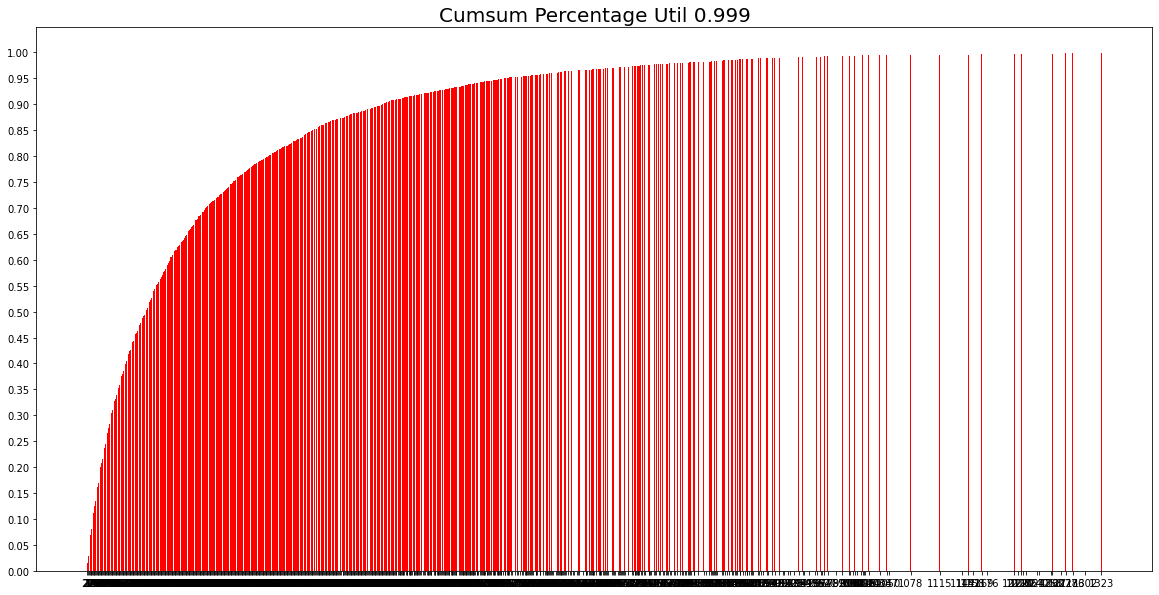

In [13]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title("Cumsum Percentage Util 0.999", size=20)
plt.show()

In [14]:
data.isnull().sum()

UserId    0
ItemId    0
Rating    0
Time      0
UTC       0
dtype: int64

In [15]:
data['UTC'] = data['Time']
data['UTC'] = pd.to_datetime(data['UTC'], unit='s')

In [16]:
data.head()

,UserId,ItemId,Rating,Time,UTC
1000138,6040,858,4,956703932,2000-04-25 23:05:32
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
1000192,6040,2019,5,956703977,2000-04-25 23:06:17


### Data Cleansing

In [17]:
# short_session을 제거한 다음에 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
# 이를 위해 반복문을 통하여 지속적으로 제거

def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data 

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,UTC
1000138,6040,858,4,956703932,2000-04-25 23:05:32
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
1000192,6040,2019,5,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
825793,4958,2399,1,1046454338,2003-02-28 17:45:38
825438,4958,1407,5,1046454443,2003-02-28 17:47:23
825724,4958,3264,4,1046454548,2003-02-28 17:49:08
825731,4958,2634,3,1046454548,2003-02-28 17:49:08


## Train / Valid / Test split

In [69]:
data['UTC'].max(), data['UTC'].min()

(Timestamp('2003-02-28 17:49:50'), Timestamp('2000-04-25 23:05:32'))

In [70]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['UTC'].max()
    session_last_time = data.groupby('UserId')['UTC'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    return before_date, after_date

In [71]:
tr, test = split_by_date(data, n_days=30)
tr, val = split_by_date(tr, n_days=30)

In [72]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["UTC"].min()}\n'
          f'\t Last Time : {data["UTC"].max()}\n')
    
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 919203
	 Sessions: 5858
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 02:26:14

* valid Set Stats Info
	 Events: 29477
	 Sessions: 79
	 Items: 2960
	 First Time : 2000-05-05 17:20:21
	 Last Time : 2003-01-29 03:00:40

* test Set Stats Info
	 Events: 50925
	 Sessions: 103
	 Items: 3172
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [73]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

In [74]:
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [75]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [76]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [77]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,UTC,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,0
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,1
999873,6040,593,5,956703954,2000-04-25 23:05:54,2
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,3
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,4
999877,6040,1419,3,956704056,2000-04-25 23:07:36,5
999920,6040,213,5,956704056,2000-04-25 23:07:36,6
999967,6040,3111,5,956704056,2000-04-25 23:07:36,7
999868,6040,573,4,956704056,2000-04-25 23:07:36,8
999980,6040,3505,4,956704056,2000-04-25 23:07:36,9


In [78]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [79]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,UTC,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,0
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,1
999873,6040,593,5,956703954,2000-04-25 23:05:54,2
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,3
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,4
999877,6040,1419,3,956704056,2000-04-25 23:07:36,5
999920,6040,213,5,956704056,2000-04-25 23:07:36,6
999967,6040,3111,5,956704056,2000-04-25 23:07:36,7
999868,6040,573,4,956704056,2000-04-25 23:07:36,8
999980,6040,3505,4,956704056,2000-04-25 23:07:36,9


In [80]:
iter_ex = iter(tr_data_loader)

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 106 210]
Label Item Idx are :       [  1  54 177 211]
Previous Masked Input Idx are []


## 모델 구성

In [81]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [82]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [83]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [84]:
args_1 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model_1 = create_model(args_1)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [85]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [86]:
train_model(model_1, args_1)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  29%|██▊       | 131/459 [00:47<01:59,  2.75it/s]


	 - Recall@20 epoch 1: 0.187142
	 - MRR@20    epoch 1: 0.041789



Evaluation:  29%|██▊       | 131/459 [00:46<01:56,  2.82it/s]


	 - Recall@20 epoch 2: 0.223402
	 - MRR@20    epoch 2: 0.048210



Evaluation:  29%|██▊       | 131/459 [00:46<01:55,  2.84it/s]


	 - Recall@20 epoch 3: 0.231751
	 - MRR@20    epoch 3: 0.052914



## 모델 테스트

In [87]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [88]:
test_model(model_1, args_1, test)

Evaluation:  53%|█████▎    | 418/794 [02:25<02:11,  2.87it/s]

	 - Recall@20: 0.234300
	 - MRR@20: 0.055709



## Learning Rate 변경해보기

In [89]:
args_2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0005, epochs=3, k=20)
model_2 = create_model(args_2)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [90]:
train_model(model_2, args_2)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  29%|██▊       | 131/459 [00:49<02:03,  2.65it/s]


	 - Recall@20 epoch 1: 0.104365
	 - MRR@20    epoch 1: 0.022528



Evaluation:  29%|██▊       | 131/459 [00:45<01:54,  2.86it/s]


	 - Recall@20 epoch 2: 0.193106
	 - MRR@20    epoch 2: 0.042800



Evaluation:  29%|██▊       | 131/459 [00:47<01:57,  2.79it/s]


	 - Recall@20 epoch 3: 0.217796
	 - MRR@20    epoch 3: 0.047683



In [91]:
test_model(model_2, args_2, test)

Evaluation:  53%|█████▎    | 418/794 [02:28<02:13,  2.82it/s]

	 - Recall@20: 0.216582
	 - MRR@20: 0.049415



## epoch 늘려기

In [92]:
args_3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0005, epochs=10, k=20)
model_3 = create_model(args_2)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      520200    
_________________________________________________________________
dropout_4 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (64, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [93]:
train_model(model_3, args_3)

model = tf.keras.models.load_model(data_path / 'trained_model')

Evaluation:  29%|██▊       | 131/459 [00:50<02:06,  2.60it/s]


	 - Recall@20 epoch 1: 0.106393
	 - MRR@20    epoch 1: 0.023538



Evaluation:  29%|██▊       | 131/459 [00:47<01:57,  2.79it/s]


	 - Recall@20 epoch 2: 0.197877
	 - MRR@20    epoch 2: 0.043776



Evaluation:  29%|██▊       | 131/459 [00:46<01:55,  2.84it/s]


	 - Recall@20 epoch 3: 0.217796
	 - MRR@20    epoch 3: 0.046693



Evaluation:  29%|██▊       | 131/459 [00:46<01:55,  2.84it/s]


	 - Recall@20 epoch 4: 0.228769
	 - MRR@20    epoch 4: 0.049429



Evaluation:  29%|██▊       | 131/459 [00:46<01:56,  2.81it/s]


	 - Recall@20 epoch 5: 0.233540
	 - MRR@20    epoch 5: 0.050866



Evaluation:  29%|██▊       | 131/459 [00:45<01:52,  2.91it/s]


	 - Recall@20 epoch 6: 0.237953
	 - MRR@20    epoch 6: 0.051930



Evaluation:  29%|██▊       | 131/459 [00:44<01:52,  2.93it/s]


	 - Recall@20 epoch 7: 0.240100
	 - MRR@20    epoch 7: 0.053355



Evaluation:  29%|██▊       | 131/459 [00:44<01:51,  2.94it/s]


	 - Recall@20 epoch 8: 0.239623
	 - MRR@20    epoch 8: 0.053900



Evaluation:  29%|██▊       | 131/459 [00:44<01:51,  2.94it/s]


	 - Recall@20 epoch 9: 0.241412
	 - MRR@20    epoch 9: 0.055263



Evaluation:  29%|██▊       | 131/459 [00:44<01:50,  2.98it/s]


	 - Recall@20 epoch 10: 0.242366
	 - MRR@20    epoch 10: 0.054266



In [94]:
test_model(model_3, args_3, test)

Evaluation:  53%|█████▎    | 418/794 [02:20<02:06,  2.98it/s]

	 - Recall@20: 0.244281
	 - MRR@20: 0.059535



## 회고

데이터톤을 시작하기 전에 끝내고 싶어 허겁지겁 해서 얼렁뚱땅 넘어간 듯한 익스다.
어려웠던 점은 노드처럼 SessionId 가 아니라 UserId인것, 그리고 UTC타임으로 되어 있어 변환해 주는 것 정도가 어렵게 느껴진거 같다. 그 이외에 몇가지 오류가 있었는데 기억이 나지 않는다. 데이터톤을 하면서 굉장히 크게 다가온 부분이 기록의 중요성이 얼마나 큰지 느꼈다. 얘기했던 혹은 생각했던 모든 아이디어를 기록해서 정리하는 것만해도 여러번 쓸데없는 행동들을 줄여 시간낭비를 막을 수 있다. 오류를 잡는 과정을 기록해 놓고 다시 보기만 해도 상기시키는데 충분하다.